In [0]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import KFold
import mlflow

/databricks/python/lib/python3.11/site-packages/mlflow/protos/service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


In [0]:
!pip install mlflow==1.20.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 152.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.5/632.5 kB 26.4 MB/s eta 0:00:00
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158151 sha256=de7553580e474dfad705b4e0ead39a8783e9828f6acfedc09827095fc7482cf6
  Stored in directory: /home/spark-c9eda0d5-58a3-458f-acdf-bf/.cache/pip/wheels/a4/64/d3/93adc7191aec3e609ce577eca23285c98d9cdd7750808e765e
Successfully built alembic
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Not uninstalling click at /databricks/python3/lib/python3.11/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-c9eda0d5-58a3-458f-acdf-bf0a02dc5b96
  

In [0]:
df = pd.read_csv("creditcard.csv")

In [0]:
df = df.drop("Time", axis=1) # cette colonne n'apporte rien à notre analyse 
df.head()
  

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: xlabel='Class', ylabel='count'>

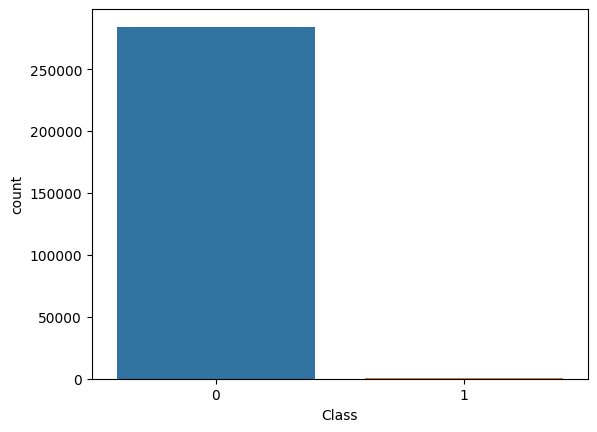

In [0]:
sns.countplot(x='Class',data=df)

In [0]:
normal = df[df.Class == 0].sample(frac=0.5,random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [0]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


In [0]:
normal_train, normal_test = train_test_split(normal,test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
normal_train, normal_validate = train_test_split(normal_train,test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [0]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

In [0]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

In [0]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [0]:
print("Training sets:\nx_train: {} \ny_train:{}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test:{}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} \ny_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 29) 
y_train:(85588,)

Testing sets:
x_test: (28531, 29) 
y_test:(28531,)

Validation sets:
x_validate: (28531, 29) 
y_validate: (28531,)


In [0]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

StandardScaler()

In [0]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [0]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [0]:
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay

def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    roc_plot = RocCurveDisplay.from_estimator(sk_model, x_test, y_test, name='Scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

In [0]:
#to configure your DataBricks CLI
token = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
dbutils.fs.put("file:///root/.databrickscfg","[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken ="+token,overwrite=True)

'[REDACTED]'

/databricks/python/lib/python3.11/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Train Accuracy: 99.893%
Auc Score: 85.341%
Eval Accuracy: 99.874%


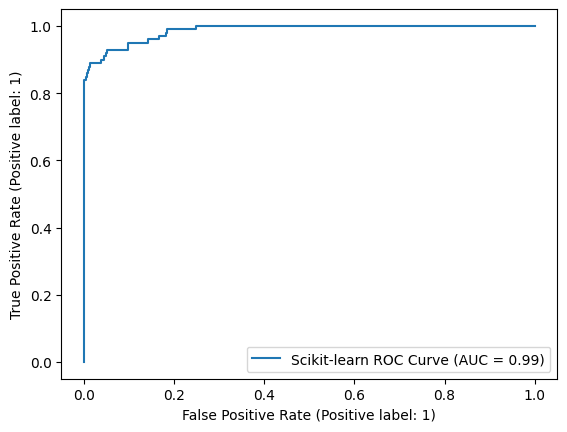

2025/11/16 15:58:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-623d5-a37e2-3bc9a-a/tmp6raxtbr_/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/11/16 15:58:46 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 1.20.2, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/11/16 15:58:46 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlfl

Model run:  e1d58ece252e4b63a250c792defef077


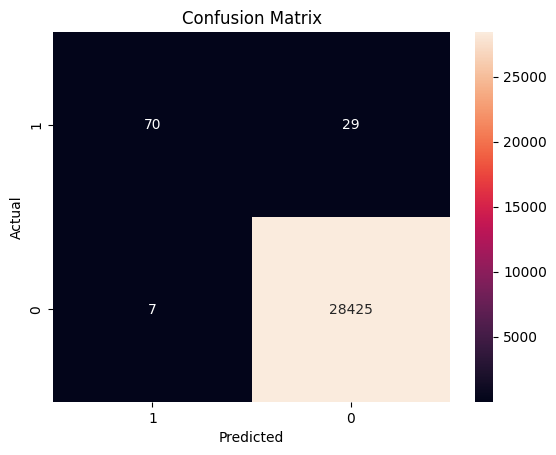

In [0]:
import mlflow

mlflow.set_registry_uri("databricks-uc")

mlflow.set_experiment(
    "/Users/zc.zakariachoukri23@gmail.com/scikit_learn_experiment1"
)

sk_model = LogisticRegression(
    random_state=None,
    max_iter=10,
    solver='newton-cg'
)

with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

Train Accuracy: 99.897%
Auc Score: 85.345%
Eval Accuracy: 99.881%


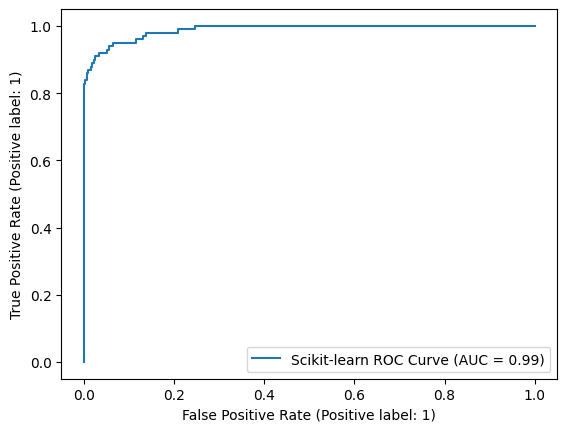

2025/11/16 16:44:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-623d5-a37e2-3bc9a-a/tmpp7jfd2hq/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/11/16 16:44:21 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 1.20.2, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/11/16 16:44:21 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlfl

Model run:  a79969d302554cbf89251e6959cda103


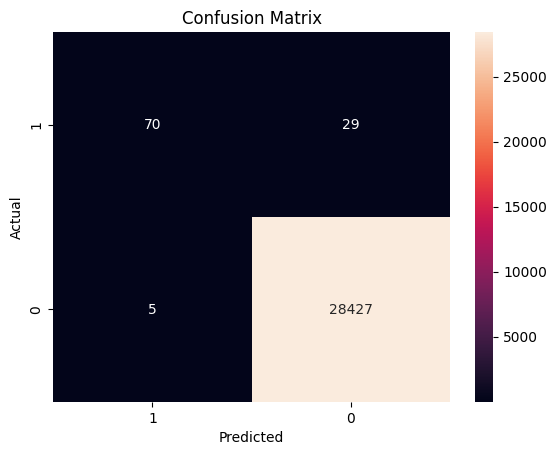

In [0]:

# define evaluation

# define search space
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
mlflow.set_experiment("/Users/zc.zakariachoukri23@gmail.com/scikit_learn_experiment1")
with mlflow.start_run():
    search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
    sk_model = search.fit(x_train, y_train)
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [0]:
all_runs = mlflow.search_runs(max_results=10)  # Note : This is pandas dataframe
display(all_runs)

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.auc_score,metrics.train_acc,metrics.eval_acc,tags.mlflow.databricks.cluster.info,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.runColor,tags.mlflow.databricks.notebook.commandID,tags.mlflow.databricks.workspaceURL,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.log-model.history,tags.mlflow.databricks.cluster.libraries,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.notebookID,tags.mlflow.databricks.notebookPath,tags.mlflow.databricks.workspaceID,tags.mlflow.databricks.webappURL,tags.mlflow.source.type
a79969d302554cbf89251e6959cda103,1834869671727596,FINISHED,dbfs:/databricks/mlflow-tracking/1834869671727596/a79969d302554cbf89251e6959cda103/artifacts,2025-11-16T16:00:29.370Z,2025-11-16T16:44:22.280Z,0.8534474244413751,0.9989718184792261,0.998808313763976,"{""cluster_name"":"""",""spark_version"":""client.2.5-aarch64-scala2.12"",""autotermination_minutes"":120}",/Users/zc.zakariachoukri23@gmail.com/5. MLflow-DataBricks,zc.zakariachoukri23@gmail.com,luminous-smelt-61,#479a5f,1763307149653_8904898960523083196_c6c4977a8ecb4f3e9c5a5587d1246446,https://dbc-15fdc886-7696.cloud.databricks.com,1763311462496,"[{""artifact_path"":""log_reg_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""},""python_version"":""3.11.10""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.3.0"",""serialization_format"":""cloudpickle"",""code"":null}},""utc_time_created"":""2025-11-16 16:44:21.754688""}]","{""installable"":[],""redacted"":[]}",1116-153228-s2gdbqog-v2n,1834869671727587,/Users/zc.zakariachoukri23@gmail.com/5. MLflow-DataBricks,2260586018336092,https://dbc-15fdc886-7696.cloud.databricks.com,NOTEBOOK
e1d58ece252e4b63a250c792defef077,1834869671727596,FINISHED,dbfs:/databricks/mlflow-tracking/1834869671727596/e1d58ece252e4b63a250c792defef077/artifacts,2025-11-16T15:58:43.587Z,2025-11-16T15:58:47.106Z,0.8534122528037835,0.9989250829555545,0.9987382145736217,"{""cluster_name"":"""",""spark_version"":""client.2.5-aarch64-scala2.12"",""autotermination_minutes"":120}",/Users/zc.zakariachoukri23@gmail.com/5. MLflow-DataBricks,zc.zakariachoukri23@gmail.com,abrasive-chimp-497,#da4c4c,1763307149653_8349639672555936606_c0d4298c233c40a1a312a105a95ffef9,https://dbc-15fdc886-7696.cloud.databricks.com,1763308727283,"[{""artifact_path"":""log_reg_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""},""python_version"":""3.11.10""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.3.0"",""serialization_format"":""cloudpickle"",""code"":null}},""utc_time_created"":""2025-11-16 15:58:46.527251""}]","{""installable"":[],""redacted"":[]}",1116-153228-s2gdbqog-v2n,1834869671727587,/Users/zc.zakariachoukri23@gmail.com/5. MLflow-DataBricks,2260586018336092,https://dbc-15fdc886-7696.cloud.databricks.com,NOTEBOOK
10c0b7ba61a6488b866b7d10f67ea225,1834869671727596,FINISHED,dbfs:/databricks/mlflow-tracking/1834869671727596/10c0b7ba61a6488b866b7d10f67ea225/artifacts,2025-11-16T15:56:42.741Z,2025-11-16T15:56:46.016Z,0.8534122528037835,0.9989250829555545,0.9987382145736217,"{""cluster_name"":"""",""spark_version"":""client.2.5-aarch64-scala2.12"",""autotermination_minutes"":120}",/Users/zc.zakariachoukri23@gmail.com/5. MLflow-DataBricks,zc.zakariachoukri23@gmail.com,stylish-goat-152,#5387dd,1763307149653_8467748418534215017_68371c1e794849d7bc20bb62bb5977ed,https://dbc-15fdc886-7696.cloud.databricks.com,1763308606233,"[{""artifact_path"":""log_reg_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""p

TAF: 

1. réexécutez la cellule 18 en utilisant d'autres modèle ML de SKlearn 
2. comparez vos résultats en utilisant l'outil de comparaison de MLFlow

/databricks/python/lib/python3.11/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Train Accuracy: 99.893%
Auc Score: 85.341%
Eval Accuracy: 99.874%


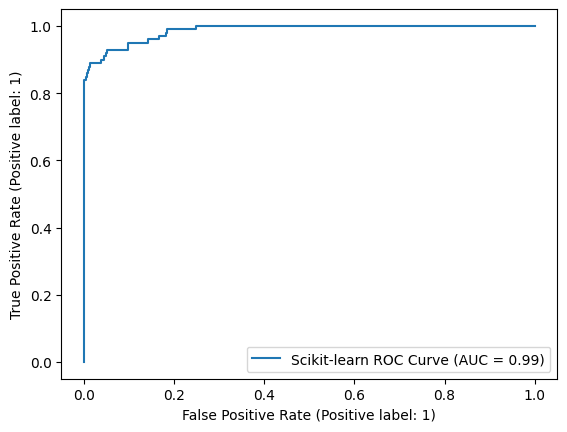

2025/11/16 16:49:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-623d5-a37e2-3bc9a-a/tmpedq5li0x/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/11/16 16:49:37 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 1.20.2, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/11/16 16:49:37 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlfl

Model run (LogisticRegression): 9e451acb59504e9686cea8de3c99e4d6
Train Accuracy: 100.000%
Auc Score: 88.880%
Eval Accuracy: 99.905%


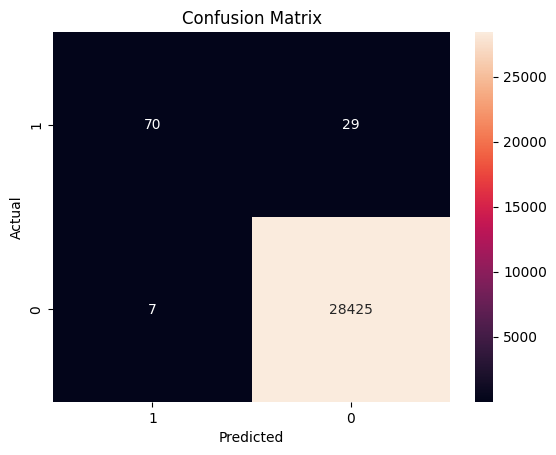

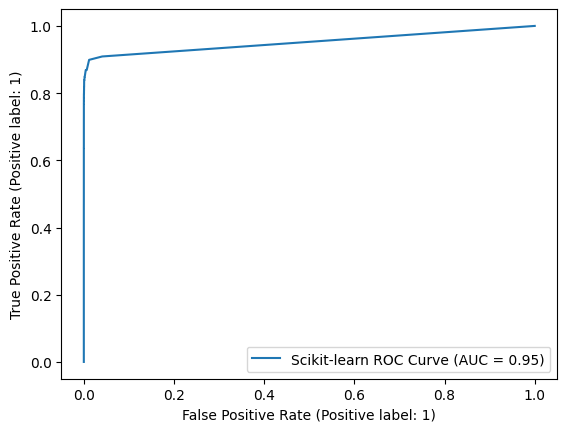

2025/11/16 16:50:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-623d5-a37e2-3bc9a-a/tmpc3r9_3o6/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/11/16 16:50:54 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 1.20.2, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/11/16 16:50:54 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlfl

Model run (RandomForest): 3d8deffc5c804f1d825ef7d6d82ead78
Train Accuracy: 99.943%
Auc Score: 83.833%
Eval Accuracy: 99.877%


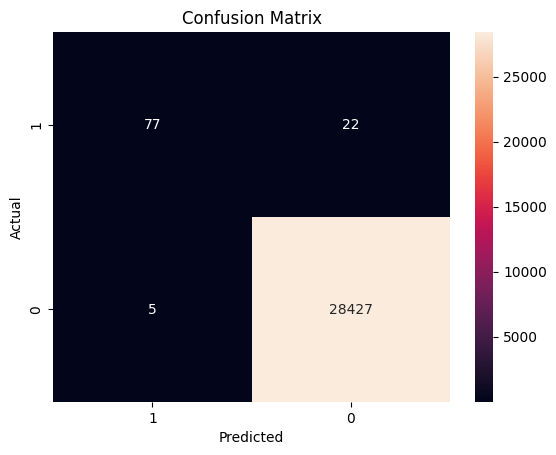

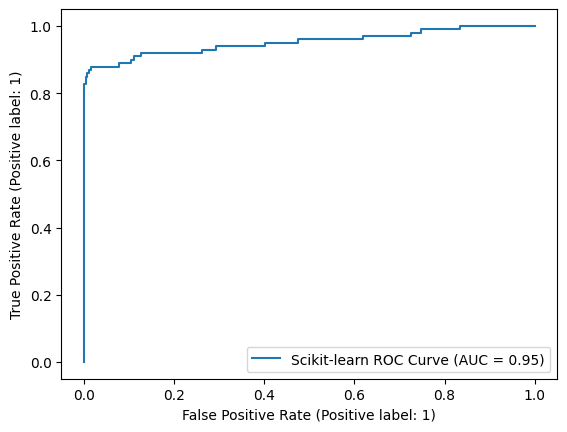

2025/11/16 16:53:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-623d5-a37e2-3bc9a-a/tmpfjeuw6k4/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/11/16 16:53:40 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 1.20.2, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/11/16 16:53:41 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlfl

Model run (SVC): 0aa10e21d9d245458e00c6af0f092324


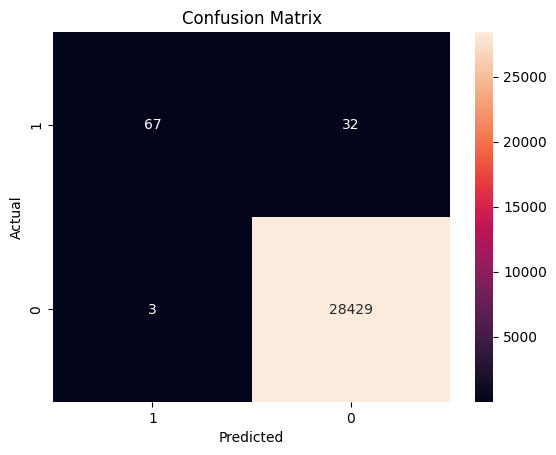

---------------------------------------------------------------------------
RestException                             Traceback (most recent call last)
File <command-5104018252392466>, line 26
     23     mlflow.end_run()
     25 # Comparaison des résultats avec l'outil MLflow
---> 26 mlflow.search_runs(filter_string=f"run_id IN ('{'',''.join(run_ids)}')", max_results=10)

File /databricks/python/lib/python3.11/site-packages/mlflow/tracking/fluent.py:1904, in search_runs(experiment_ids, filter_string, run_view_type, max_results, order_by, output_format, search_all_experiments, experiment_names)
   1894     def pagination_wrapper_func(number_to_get, next_page_token):
   1895         return MlflowClient().search_runs(
   1896             experiment_ids,
   1897             filter_string,
   (...)
   1901             next_page_token,
   1902         )
-> 1904     runs = get_results_from_paginated_fn(
   1905         pagination_wrapper_func,
   1906         NUM_RUNS_PER_PAGE_PANDAS,
   190

In [0]:
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

mlflow.set_registry_uri("databricks-uc")
mlflow.set_experiment("/Users/zc.zakariachoukri23@gmail.com/scikit_learn_experiment1")

models = [
    ("LogisticRegression", LogisticRegression(random_state=None, max_iter=10, solver='newton-cg')),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=2020)),
    ("SVC", SVC(probability=True, random_state=2020))
]

run_ids = []

for name, model in models:
    with mlflow.start_run(run_name=name) as run:
        train(model, x_train, y_train)
        evaluate(model, x_test, y_test)
        mlflow.sklearn.log_model(model, f"{name}_model")
        print(f"Model run ({name}): {run.info.run_uuid}")
        run_ids.append(run.info.run_id)
    mlflow.end_run()

# Comparaison des résultats avec l'outil MLflow
mlflow.search_runs(filter_string=f"run_id IN ('{'',''.join(run_ids)}')", max_results=10)